Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential

In [5]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/Upgrad/CNN/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/Upgrad/CNN/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Reserve 20% for validation
    subset="training",
    seed=123,  # Set seed for reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size  # Batch size for training
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

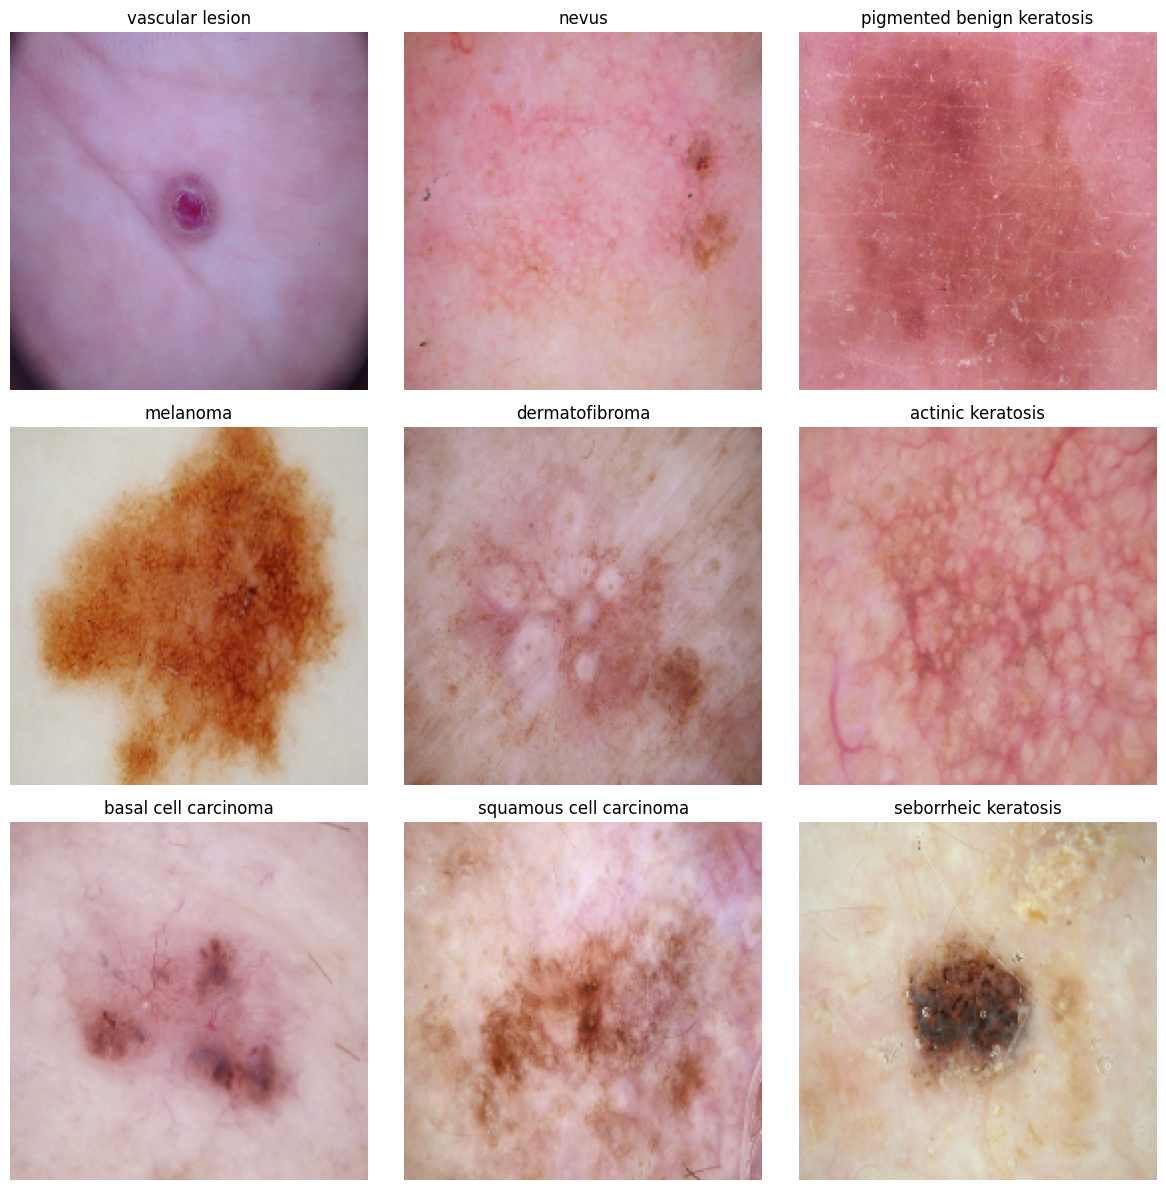

In [12]:
import matplotlib.pyplot as plt

# Prepare a figure
plt.figure(figsize=(12, 12))

# Create a dictionary to track if we have visualized each class
visualized_classes = {class_name: False for class_name in class_names}

# Iterate through the dataset
for images, labels in train_ds:
    for i in range(len(labels)):
        class_name = class_names[labels[i].numpy()]
        if not visualized_classes[class_name]:  # Check if this class is already visualized
            plt.subplot(3, 3, len([v for v in visualized_classes.values() if v]) + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            visualized_classes[class_name] = True

        # Stop once all classes are visualized
        if all(visualized_classes.values()):
            break
    if all(visualized_classes.values()):
        break

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
model = models.Sequential([
        # Normalize pixel values to [0, 1]
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')  # Output layer
    ])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,177,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,199,945 (126.65 MB)

 Trainable params: 33,199,753 (126.65 MB)

 Non-trainable params: 192 (768.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.2929 - loss: 34.8074 - val_accuracy: 0.1499 - val_loss: 37.0825
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.2623 - loss: 2.2103 - val_accuracy: 0.1499 - val_loss: 79.4400
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2890 - loss: 2.0325 - val_accuracy: 0.1499 - val_loss: 103.0163
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3529 - loss: 1.8227 - val_accuracy: 0.1499 - val_loss: 111.2020
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3839 - loss: 1.6553 - val_accuracy: 0.1499 - val_loss: 103.5186
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3639 - loss: 1.6960 - val_accuracy: 0.1588 - val_loss: 70.6757
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4372 - loss: 1.5432 - val_accuracy: 0.1879 - val_loss: 45.6988
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4685 - loss: 1.4930 - val_accuracy

### Visualizing training results

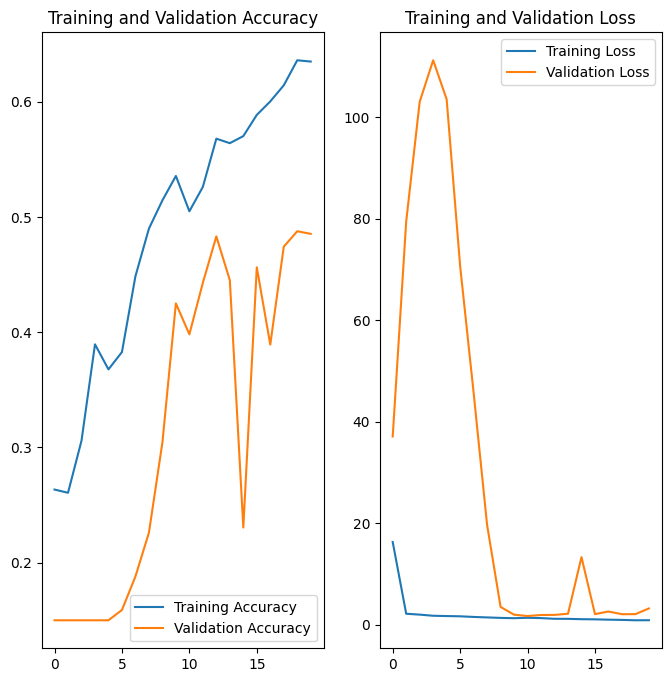

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
1.   The validation accuracy initially improves but starts fluctuating or declining after reaching a certain point (around epoch 12-15)
2.   The validation loss decreases initially but starts increasing sharply after epoch 10, creating a gap between the training and validation loss

### **The divergence between training and validation metrics (accuracy and loss) after epoch 10 suggests that the model is starting to overfit the training data.**


In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Data augmentation strategy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create ImageDataGenerator with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split to 20%
)

# Create ImageDataGenerator for validation data (no augmentation, only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator (80% of the data)
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use the 'training' subset (80%)
)

# Validation data generator (20% of the data)
validation_generator = validation_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the 'validation' subset (20%)
)



Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


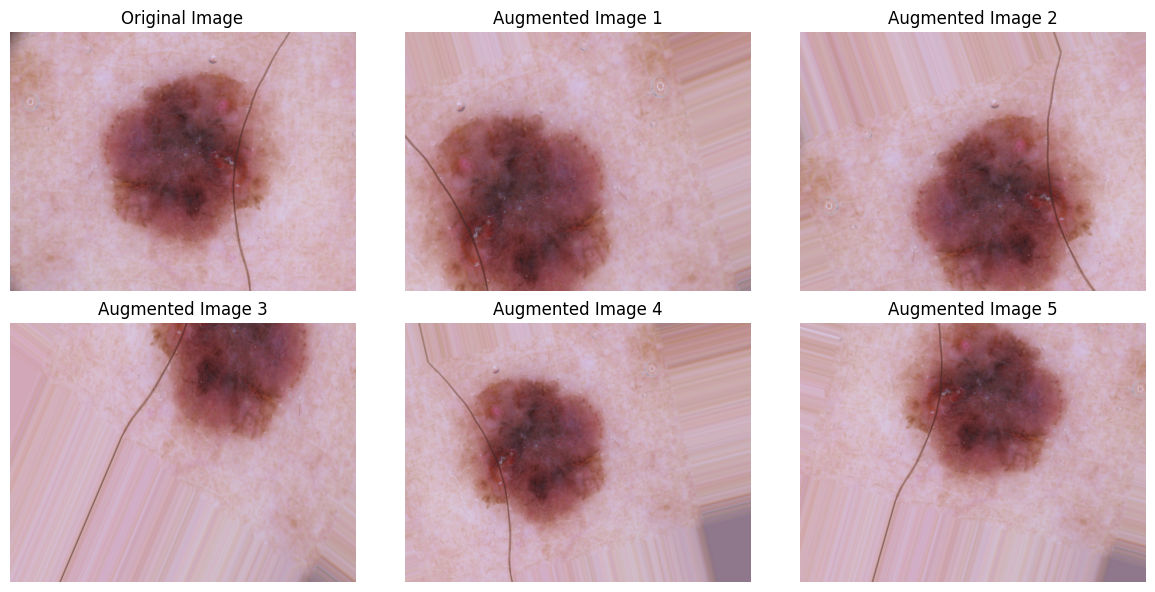

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
from tensorflow.keras.preprocessing import image
def visualize_augmentation(image_path):
    # Load an example image
    img = image.load_img(image_path)
    img_array = image.img_to_array(img)  # Convert image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Create ImageDataGenerator with augmentation strategy (no rescaling for visualization)
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate augmented images
    augmented_images = datagen.flow(img_array, batch_size=1)

    # Plot the original image and some augmented images
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Display augmented images
    for i in range(2, 7):
        augmented_img = next(augmented_images)[0].astype('uint8')  # Get augmented image from the generator
        plt.subplot(2, 3, i)
        plt.imshow(augmented_img)
        plt.title(f'Augmented Image {i-1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = data_dir_train / "melanoma" / "ISIC_0000139.jpg"  # Replace with the path to your training image
visualize_augmentation(image_path)


### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = models.Sequential([
    # Normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dropout layer to prevent overfitting (if observed)
    layers.Dropout(0.3),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dropout layer to prevent overfitting
    layers.Dropout(0.4),

    # Third convolutional block (optional, deeper model)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),

    # Dropout layer before the final output layer
    layers.Dropout(0.5),

    # Output layer with softmax for multi-class classification
    layers.Dense(len(class_names), activation='softmax')  # Output layer with len(class_names) neurons
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the model

In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Since this is a multi-class classification problem
    metrics=['accuracy']
)

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Set the number of epochs as required
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 742ms/step - accuracy: 0.2012 - loss: 23.3390 - val_accuracy: 0.2043 - val_loss: 10.4928
Epoch 2/20
 1/56 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3438 - loss: 2.0430

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3438 - loss: 2.0430 - val_accuracy: 0.2500 - val_loss: 9.8996
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 650ms/step - accuracy: 0.2378 - loss: 2.0879 - val_accuracy: 0.2019 - val_loss: 24.3205
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1562 - loss: 2.1626 - val_accuracy: 0.2857 - val_loss: 23.5011
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 647ms/step - accuracy: 0.2736 - loss: 2.0425 - val_accuracy: 0.1971 - val_loss: 38.8498
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4375 - loss: 1.9591 - val_accuracy: 0.3571 - val_loss: 33.3802
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 628ms/step - accuracy: 0.2855 - loss: 2.0568 - val_accuracy: 0.2115 - val_loss: 51.2557
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.2500 - loss: 2.2478 - val_accuracy: 0.1429 - val_loss: 53.3104
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 645ms/step - accuracy: 0.2602 - loss: 2.0728 - val_accuracy: 0.2139 - 

### Visualizing the results

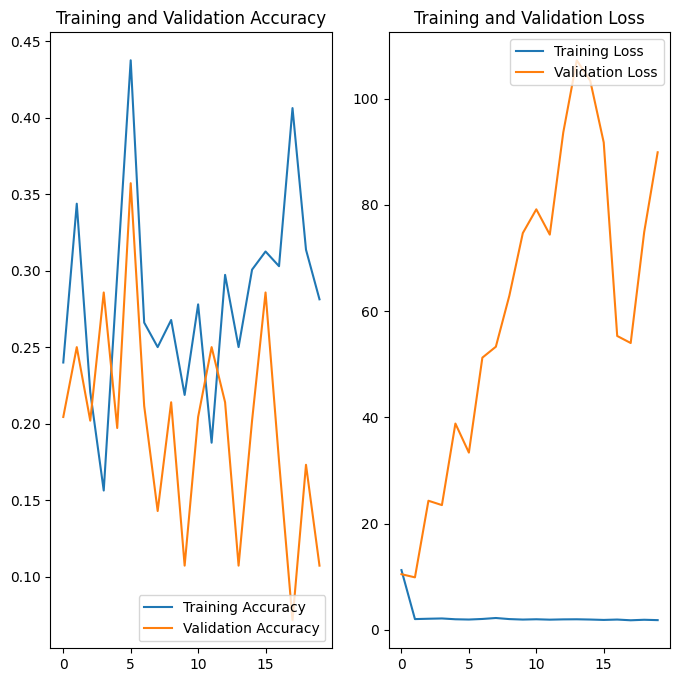

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
**Observation**

The training accuracy shows an increasing trend and stabilizes around 0.35.

The validation accuracy fluctuates a lot and remains generally lower than the training accuracy, peaking around 0.25.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class indices mapping: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
actinic keratosis: 92
basal cell carcinoma: 301
dermatofibroma: 76
melanoma: 351
nevus: 286
pigmented benign keratosis: 370
seborrheic keratosis: 62
squamous cell carcinoma: 145
vascular lesion: 112


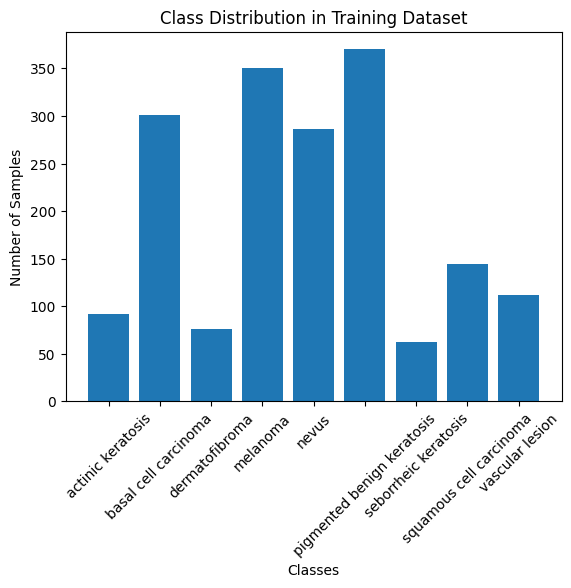

In [25]:
# Get the class indices mapping
class_indices = train_generator.class_indices
print("Class indices mapping:", class_indices)

# Get the counts of each class in the training data
class_counts = np.bincount(train_generator.classes)

# Print class-wise distribution
for class_name, class_index in class_indices.items():
    print(f"{class_name}: {class_counts[class_index]}")

# Visualize the class distribution (optional)
import matplotlib.pyplot as plt

plt.bar(class_indices.keys(), class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? **seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? **pigmented benign keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    class_path = path_to_training_dataset.joinpath(i)
    p = Augmentor.Pipeline(str(class_path))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785E7D346E30>: 100%|██████████| 500/500 [00:24<00:00, 20.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785E97B621D0>: 100%|██████████| 500/500 [00:20<00:00, 24.06 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785EDC184340>: 100%|██████████| 500/500 [00:19<00:00, 26.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x785E7D3C59F0>: 100%|██████████| 500/500 [01:19<00:00,  6.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1028x753 at 0x785E97B62410>: 100%|██████████| 500/500 [01:16<00:00,  6.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785EB9595750>: 100%|██████████| 500/500 [00:21<00:00, 22.81 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x785EDC5603D0>: 100%|██████████| 500/500 [00:39<00:00, 12.66 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x785EB954E1D0>: 100%|██████████| 500/500 [00:20<00:00, 24.87 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Upgrad/CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x785EB95E4310>: 100%|██████████| 500/500 [00:19<00:00, 25.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/Upgrad/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028496.jpg_d309fc13-dc2f-4b8a-a66a-4d9548aedfa1.jpg',
 '/content/drive/My Drive/Upgrad/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024770.jpg_3ba1afc8-2499-409d-a1a7-f2c28b7586e0.jpg',
 '/content/drive/My Drive/Upgrad/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028411.jpg_4edbecef-67ac-4d1f-ad25-aa090a97cd39.jpg',
 '/content/drive/My Drive/Upgrad/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027649.jpg_6e567981-28a4-41f7-bbe1-39819acb1c2d.jpg',
 '/content/drive/My Drive/Upgrad/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028376.jpg_47f91376-59db-4125-97b9-9062c1dc8d06.jpg',
 '/content/drive/My Drive/Upgrad/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026139.jpg_3544b

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


train_data = []
for image, label in train_ds:
    train_data.append({"Path": "N/A", "Label": label.numpy()})

# Convert to a DataFrame
df1 = pd.DataFrame(train_data)

# Append df2 to df1
new_df = pd.concat([df1, df2], ignore_index=True)

In [33]:
new_df['Label'].value_counts()

,count
Label,
vascular lesion,500
basal cell carcinoma,500
nevus,500
squamous cell carcinoma,500
actinic keratosis,500
...,...
"[2, 2, 3, 3, 4, 5, 4, 5, 5, 5, 1, 4, 4, 5, 1, 5, 5, 4, 5, 3, 0, 1, 7, 3, 7, 7, 5, 1, 1, 2, 7, 3]",1
"[3, 3, 5, 4, 3, 3, 3, 5, 3, 1, 5, 3, 5, 3, 8, 3, 1, 1, 5, 5, 3, 5, 2, 1, 3, 5, 7, 6, 1, 4, 3, 7]",1
"[1, 1, 6, 3, 1, 0, 3, 3, 0, 5, 1, 4, 0, 3, 5, 1, 1, 2, 4, 3, 3, 1, 1, 1, 3, 1, 3, 7, 7, 6, 5, 8]",1


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:

data_dir_train=pathlib.Path("/content/drive/My Drive/Upgrad/CNN/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', #Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
# Define the model
model = models.Sequential([
    # Normalization layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values to [0, 1]

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),  # Batch normalization after convolution
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Dropout to prevent overfitting

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout before the final layer

    # Output layer for multi-class classification
    layers.Dense(len(class_names), activation='softmax')  # Use len(class_names) for the number of classes
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [42]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use this loss for multi-class classification
    metrics=['accuracy']
)

#### **Todo:**  Train your model

In [44]:
epochs = 30
## Your code goes here, use 50 epochs.
history =model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,  # Set the number of epochs as required
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - accuracy: 0.4591 - loss: 1.4966 - val_accuracy: 0.1827 - val_loss: 13.9231
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2500 - loss: 1.9155 - val_accuracy: 0.1429 - val_loss: 23.7444
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 619ms/step - accuracy: 0.4983 - loss: 1.4540 - val_accuracy: 0.1803 - val_loss: 24.5960
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4062 - loss: 1.4723 - val_accuracy: 0.0714 - val_loss: 16.1193
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 620ms/step - accuracy: 0.4897 - loss: 1.4639 - val_accuracy: 0.1899 - val_loss: 76.8954
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5312 - loss: 1.4237 - val_accuracy: 0.2857 - val_loss: 75.2148
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 630ms/step - accuracy: 0.4847 - loss: 1.4522 - val_accuracy: 0.1370 - val_loss: 81.9868
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5312 - loss: 1.3103 - val_accuracy:

#### **Todo:**  Visualize the model results

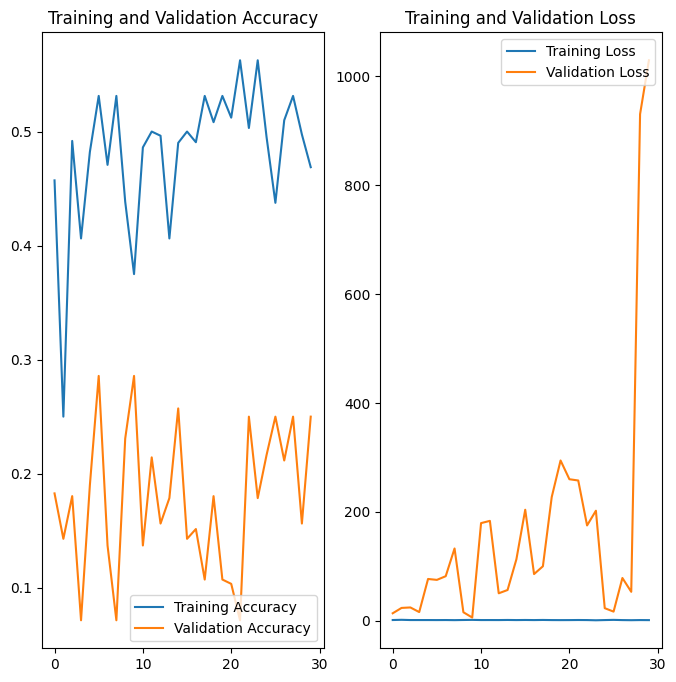

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Training accuracy hovers around ~50% without substantial improvement. Validation accuracy stagnates below 30%, indicating potential underfitting or difficulty in learning meaningful patterns from the data. To improve , we can use a learning rate scheduler or manually reduce the learning rate .Adjust early stopping patience and add a baseline to stop training if no meaningful progress is made: